In [129]:
from rdkit import Chem
from rdkit.Chem import AllChem,Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
#----------------------------------------------------
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import BayesianRidge
from scipy import stats
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv(r"C:\Users\gauri\Downloads\export (1).csv")
df



,smiles,property,value
0,[*]CC([*])C,Eat,-5.14
1,[*]CC([*])F,Eat,-5.18
2,[*]CC([*])(F)F,Eat,-5.21
3,[*]C(F)C([*])(F)F,Eat,-5.11
4,[*]CCC(F)(F)C([*])(F)F,Eat,-5.21
...,...,...,...
6260,[*]C(F)(F)C(F)(F)C(S1)=CC=C1C(S2)=CC=C2[*],eps,4.36
6261,[*]C(F)(F)C(F)(F)C(=O)O[*],eps,3.31
6262,[*]C(F)(F)C(=O)C(F)(F)C(S1)=CC=C1[*],eps,4.05
6263,[*]C(F)(F)C(=O)C(F)(F)C(C=C1)=CC=C1[*],eps,3.57


In [3]:
def canonical(smiles):
    
    a,b = [],[]
    
    for i in smiles:
        a.append(Chem.MolFromSmiles(i))
        
    for j in a:
        b.append(Chem.MolToSmiles(j))
                 
    return b

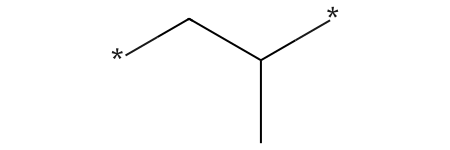

In [4]:
test = "[*]CC([*])C"
t = Chem.MolFromSmiles(test)
t

In [5]:
Chem.MolToSmiles(t)

'*CC(*)C'

In [6]:
Canon= canonical(df.smiles)
df['smiles'] = Canon
df

,smiles,property,value
0,*CC(*)C,Eat,-5.14
1,*CC(*)F,Eat,-5.18
2,*CC(*)(F)F,Eat,-5.21
3,*C(F)C(*)(F)F,Eat,-5.11
4,*CCC(F)(F)C(*)(F)F,Eat,-5.21
...,...,...,...
6260,*c1ccc(-c2ccc(C(F)(F)C(*)(F)F)s2)s1,eps,4.36
6261,*OC(=O)C(F)(F)C(*)(F)F,eps,3.31
6262,*c1ccc(C(F)(F)C(=O)C(*)(F)F)s1,eps,4.05
6263,*c1ccc(C(F)(F)C(=O)C(*)(F)F)cc1,eps,3.57


In [4]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] 
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(df['smiles'])

In [26]:
df_200 = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_200

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,7.465278,-2.404514,7.465278,0.724792,0.414720,42.081,36.033,42.046950,18,0,...,0,0,0,0,0,0,0,0,0,0
1,12.361111,-2.118056,12.361111,0.666667,0.409424,46.044,43.020,46.021878,18,0,...,0,0,0,0,0,0,0,0,0,0
2,12.027778,-2.868056,12.027778,0.854167,0.427904,64.034,62.018,64.012457,24,0,...,0,0,0,0,0,0,0,0,0,0
3,11.986111,-3.201389,11.986111,1.187500,0.441842,82.024,81.016,82.003035,30,0,...,0,0,0,0,0,0,0,0,0,0
4,12.941875,-4.883681,12.941875,1.453681,0.510440,128.068,124.036,128.024913,48,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6260,13.869230,-4.441628,13.869230,0.020181,0.737828,264.268,260.236,263.969055,84,0,...,0,0,0,0,0,0,0,2,0,0
6261,12.202454,-4.574653,12.202454,1.048588,0.534777,144.023,144.023,143.983442,52,0,...,0,0,0,0,0,0,0,0,0,0
6262,13.544977,-4.337917,13.544977,0.343579,0.694102,210.151,208.135,209.976249,70,0,...,0,0,0,0,0,0,0,1,0,0
6263,13.883065,-4.723495,13.883065,0.052901,0.684136,204.122,200.090,204.019828,74,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
dfeps = df.iloc[392:823,:]

In [28]:
y = dfeps.value
x= df_200.iloc[392:823,:]


In [29]:
def scale_data(X):
    xmean = X.mean(axis=0)  # average of every column
    xstd = X.std(axis=0)
    data = (X - xmean) / xstd
    return data
x1=scale_data(x)

In [30]:
x1 = x1.dropna(axis=1,how = 'all')
x1

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,FpDensityMorgan1,...,fr_nitrile,fr_nitro,fr_nitro_arom,fr_phenol,fr_phenol_noOrthoHbond,fr_piperzine,fr_sulfide,fr_sulfone,fr_thiophene,fr_urea
392,-2.259317,0.974026,-2.259317,0.425023,0.504475,-1.377751,-1.370179,-1.377823,-1.386735,2.975727,...,-0.048168,-0.048168,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682
393,-2.185990,0.756371,-2.185990,0.697365,0.635609,-1.309261,-1.307979,-1.309327,-1.309455,2.309734,...,-0.048168,-0.048168,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682
394,-2.112662,0.538716,-2.112662,0.969706,0.715520,-1.240770,-1.245778,-1.240830,-1.232175,1.643740,...,-0.048168,-0.048168,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682
395,-2.140464,0.083575,-2.140464,1.753785,0.531644,-1.035299,-1.059177,-1.035341,-1.000336,0.533751,...,-0.048168,-0.048168,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682
396,-2.069013,0.196756,-2.069013,1.228046,0.562207,-1.103790,-1.121378,-1.103837,-1.077616,0.977747,...,-0.048168,-0.048168,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,-2.471921,1.845049,-2.471921,-0.503642,0.334548,-1.387595,-1.370179,-1.387674,-1.412495,1.310744,...,-0.048168,-0.048168,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682
819,0.505627,-1.283467,0.505627,0.798393,-1.435819,1.213668,1.221660,1.213192,1.060462,-0.581652,...,-0.048168,-0.048168,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682
820,0.543821,-1.307177,0.543821,0.964703,-1.590703,1.653726,1.657062,1.653264,1.498382,-0.687236,...,-0.048168,-0.048168,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682
821,0.565404,-0.744127,0.565404,0.532925,-1.504408,1.261948,1.241546,1.262499,1.318062,-0.478146,...,-0.048168,20.712371,20.712371,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682


In [31]:
reg1=MLPRegressor()
reg1.fit(x1,y)
score=cross_val_score(reg1,x1,y,cv=4)
pred_1 = reg1.predict(x1)
result1 = x1
result1['value'] = y
result1['prediction'] = pred_1.tolist()
result1.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,FpDensityMorgan1,...,fr_nitro_arom,fr_phenol,fr_phenol_noOrthoHbond,fr_piperzine,fr_sulfide,fr_sulfone,fr_thiophene,fr_urea,value,prediction
392,-2.259317,0.974026,-2.259317,0.425023,0.504475,-1.377751,-1.370179,-1.377823,-1.386735,2.975727,...,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682,34.04,39.356733
393,-2.185990,0.756371,-2.185990,0.697365,0.635609,-1.309261,-1.307979,-1.309327,-1.309455,2.309734,...,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682,20.01,38.945159
394,-2.112662,0.538716,-2.112662,0.969706,0.715520,-1.240770,-1.245778,-1.240830,-1.232175,1.643740,...,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682,21.64,33.867898
395,-2.140464,0.083575,-2.140464,1.753785,0.531644,-1.035299,-1.059177,-1.035341,-1.000336,0.533751,...,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682,31.47,38.897951
396,-2.069013,0.196756,-2.069013,1.228046,0.562207,-1.103790,-1.121378,-1.103837,-1.077616,0.977747,...,-0.048168,-0.048168,-0.048168,-0.078811,-0.064685,-0.108212,-0.108212,-0.0682,75.06,37.402202


In [32]:
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
R2 =r2_score(y,pred_1)
print('R^2 of Atomization energy:', R2)

rmse = np.sqrt(mean_squared_error(y, pred_1))
print('RMSE of Atomization energy:', rmse)

R^2 of Atomization energy: 0.583536441329648
RMSE of Atomization energy: 15.337924220607114


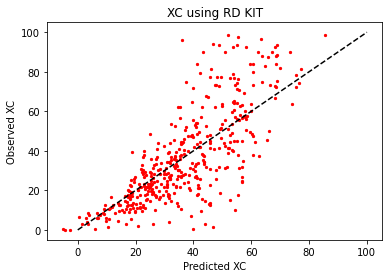

In [131]:
plt.scatter(pred_1,y,c="r",s=5)
plt.plot([0,100], [0,100] ,"k--")
plt.xlabel('Predicted XC')
plt.ylabel('Observed XC')
plt.title("XC using RD KIT");

In [34]:
from sklearn.model_selection import cross_val_score

reg2 = MLPRegressor()
  
reg2.fit(x1, y1) 

scores = cross_val_score(reg1, x1, y, cv = 5, scoring = 'neg_mean_squared_error' )


In [35]:
np.mean(scores)

-4.472983787099908

In [40]:
reg= MLPRegressor()

param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [43]:
grid = GridSearchCV(reg, param_grid, n_jobs= -1, cv=5)
grid.fit(x1,y)

print(grid.best_params_) 

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}


In [45]:
reg2 = MLPRegressor(hidden_layer_sizes= (150,100,50), max_iter= 100)

X_train1, X_test1, y_train1, y_test1 = train_test_split(x1,y,test_size=0.3)
  
reg2.fit(X_train1, y_train1) 


predictions2 = reg2.predict(X_test1)

Rmse = np.sqrt(mean_squared_error(y_test1, predictions2))
print('MSE of Atomization energy:', Rmse)

MSE of Atomization energy: 0.7535447319377012


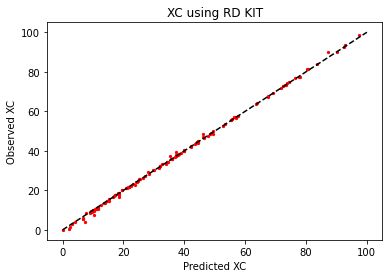

In [132]:
plt.scatter(predictions2,y_test1,c="r",s=5)
plt.plot([0,100], [0,100] ,"k--")
plt.xlabel('Predicted XC')
plt.ylabel('Observed XC')
plt.title("XC using RD KIT");